In [2]:

import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
import obspy

import torch
from chronos import ChronosPipeline
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
prediction_length = 64

## SCEDC catalog

In [4]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 2.7
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)

In [5]:
# next, we will count the number of events per day and store that as a pandas data frame with a datetme index
from collections import Counter
from pandas import DataFrame, to_datetime
import pandas as pd

# Extract event times
event_times = [event.origins[0].time.date for event in quake_catalog]

# Count the number of events per day
event_counts = Counter(event_times)

# Convert the counts to a pandas DataFrame
event_counts_df = DataFrame.from_dict(event_counts, orient='index', columns=['target'])

# Convert the index to datetime
event_counts_df.index = to_datetime(event_counts_df.index)

# Sort the DataFrame by date
event_counts_df = event_counts_df.sort_index()

# Print the DataFrame
print(event_counts_df)

            target
2016-01-02       1
2016-01-03       1
2016-01-06       2
2016-01-07       1
2016-01-09       1
...            ...
2019-12-25       3
2019-12-26       2
2019-12-27       1
2019-12-28       3
2019-12-30       1

[713 rows x 1 columns]


In [6]:
# Identify the frequency of your time series
freq = 'D'  # Daily frequency

# Create a new index with the desired frequency
new_index = pd.date_range(start=event_counts_df.index.min(), end=event_counts_df.index.max(), freq=freq)

# Reindex the DataFrame to fill in any missing dates
event_counts_df = event_counts_df.reindex(new_index)

# Fill missing values (e.g., forward fill)
event_counts_df.fillna(method='ffill', inplace=True)

# Rename the count column to target
event_counts_df = event_counts_df.rename(columns={'count': 'target'})

# Now dataset is a PandasDataset compatible with GluonTS

/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_26209/2540546850.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  event_counts_df.fillna(method='ffill', inplace=True)


(0.0, 100.0)

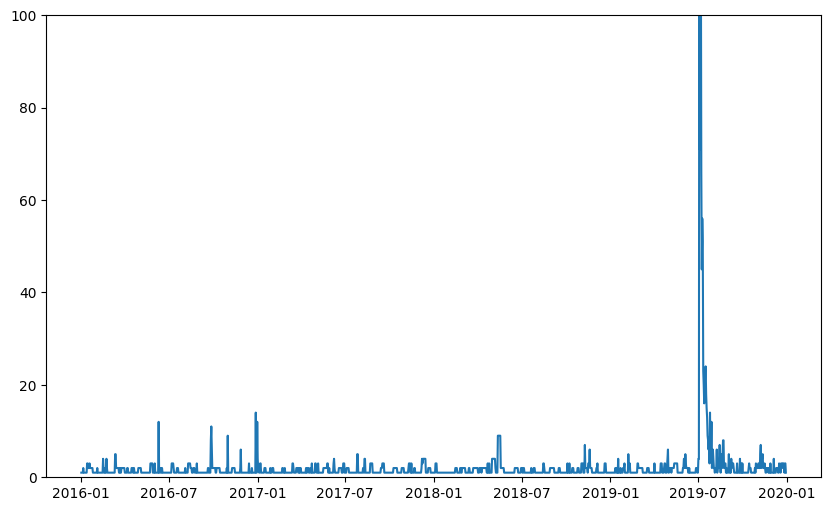

In [7]:
# plot the number of events per day
plt.figure(figsize=(10, 6))
plt.plot(event_counts_df.index, event_counts_df['target'])
plt.ylim([0, 100])

Make monthly time series

In [15]:
import pandas as pd

# Assuming event_counts is a dictionary with dates as keys and counts as values
# Convert the dictionary to a DataFrame
event_counts_df = pd.DataFrame(list(event_counts.items()), columns=['date', 'count'])

# Convert the date column to datetime
event_counts_df['date'] = pd.to_datetime(event_counts_df['date'])

# Normalize the dates to the first day of the month
event_counts_df['month'] = event_counts_df['date'].dt.to_period('M')

# Aggregate the counts by month
monthly_event_counts = event_counts_df.groupby('month')['count'].sum().reset_index()

# Convert the 'month' column back to datetime for easier plotting
monthly_event_counts['month'] = monthly_event_counts['month'].dt.to_timestamp()

print(monthly_event_counts)

        month  count
0  2016-01-01     22
1  2016-02-01     30
2  2016-03-01     20
3  2016-04-01     18
4  2016-05-01     16
5  2016-06-01     32
6  2016-07-01     17
7  2016-08-01     24
8  2016-09-01     39
9  2016-10-01     25
10 2016-11-01     19
11 2016-12-01     44
12 2017-01-01     22
13 2017-02-01     12
14 2017-03-01     22
15 2017-04-01     23
16 2017-05-01     23
17 2017-06-01     24
18 2017-07-01     17
19 2017-08-01     15
20 2017-09-01     17
21 2017-10-01     16
22 2017-11-01     19
23 2017-12-01     23
24 2018-01-01     17
25 2018-02-01     20
26 2018-03-01     15
27 2018-04-01     21
28 2018-05-01     25
29 2018-06-01     11
30 2018-07-01     18
31 2018-08-01     18
32 2018-09-01     18
33 2018-10-01     23
34 2018-11-01     30
35 2018-12-01     16
36 2019-01-01     24
37 2019-02-01     22
38 2019-03-01     12
39 2019-04-01     31
40 2019-05-01     18
41 2019-06-01     33
42 2019-07-01   1738
43 2019-08-01     95
44 2019-09-01     44
45 2019-10-01     37
46 2019-11-01

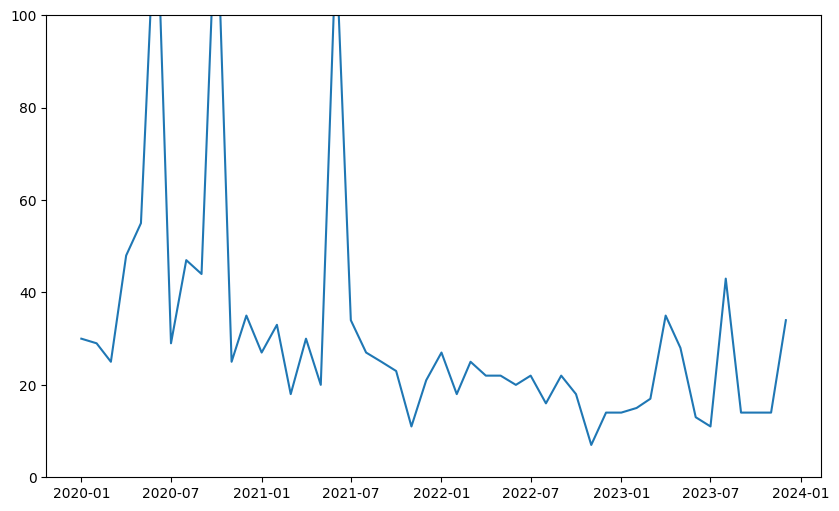

In [ ]:
# plot the number of events per month
plt.figure(figsize=(10, 6))
plt.plot(monthly_event_counts['month'], monthly_event_counts['count'])
plt.ylim([0, 100])
# plt.plot( event_counts_df['count'])
plt.show()

In [ ]:
# save the data to a csv file
monthly_event_counts.to_csv('data_scedc_catalog.csv', index=False)


QTM earthquake catalog

Synthetic Quake Catalog